<a href="https://colab.research.google.com/github/VigilCiph3r/MALICIOUS-URL-CLASSIFIER/blob/main/Malicious_URL_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Malicious URLS Classifier**

Malicious URLs or malicious website is a very serious threat to cybersecurity. Malicious URLs host unsolicited content (spam, phishing, drive-by downloads, etc.) and lure unsuspecting users to become victims of scams (monetary loss, theft of private information, and malware installation), and cause losses of billions of dollars every year. We have collected this dataset to include a large number of examples of Malicious URLs so that a machine learning-based model can be developed to identify malicious urls so that we can stop them in advance before infecting computer system or spreading through inteinternet.

**Business Understanding**

Malicious URL Classifiers are crucial for safeguarding users and organizations from a wide range of online threats. By identifying malicious websites, these classifiers help prevent users from accidentally clicking on links that could lead to malware infection, phishing attacks, or data theft. This not only protects individual users but also strengthens the overall cybersecurity posture of organizations by preventing compromised devices within their network.

Furthermore, Malicious URL Classifie…ving web browsing experiences. By filtering out malicious URLs, they can significantly reduce the number of deceptive websites encountered by users, enhancing online safety and trust. As cyberattacks constantly evolve, these classifiers act as a dynamic defense system, adapting to new threats and URL patterns to maintain a secure browsing environment.

In essence, Malicious URL Classifiers are essential tools for mitigating cybersecurity risks and promoting a safer online ecosystem for everyone.

In [ ]:
import numpy as np
import pandas as pd
import re
from urllib.parse import urlparse
import os.path

# Visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Balance Data
from imblearn.over_sampling import SMOTE

# Machine Learning (Scikit-learn Estimators, Catboost, LightGBM, etc. )
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.tree import DecisionTreeClassifier

# Hyperparameters Fine-tuning (Scikit-learn hp search, cross-validation, etc. )
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


# Evaluations
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, RocCurveDisplay, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score
from statistics import stdev
from sklearn.model_selection import KFold

import pickle


**DISK AND DATASET MOUNT**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("drive/MyDrive/content/malicious_url.csv")

In [ ]:
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [ ]:
df.tail()

,url,type
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,www.gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing
651190,www.angelfire.com/goth/devilmaycrytonite/,phishing


In [ ]:
print("Dataset shape:", df.shape)

Dataset shape: (651191, 2)


In [ ]:
df.keys()

Index(['url', 'type'], dtype='object')

In [ ]:
df['type'].value_counts()

,count
type,
benign,428103
defacement,96457
phishing,94111
malware,32520


In [ ]:
df['url'].value_counts()


In [ ]:
n_samples, n_features = df.shape
print('Number of samples:', n_samples)
print('Number of features:', n_features)

Number of samples: 651191
Number of features: 2


In [ ]:
df.isnull().sum()

,0
url,0
type,0


In [ ]:
print(df)


                                                      url        type
0                                        br-icloud.com.br    phishing
1                     mp3raid.com/music/krizz_kaliko.html      benign
2                         bopsecrets.org/rexroth/cr/1.htm      benign
3       http://www.garage-pirenne.be/index.php?option=...  defacement
4       http://adventure-nicaragua.net/index.php?optio...  defacement
...                                                   ...         ...
651186            xbox360.ign.com/objects/850/850402.html    phishing
651187       games.teamxbox.com/xbox-360/1860/Dead-Space/    phishing
651188         www.gamespot.com/xbox360/action/deadspace/    phishing
651189      en.wikipedia.org/wiki/Dead_Space_(video_game)    phishing
651190          www.angelfire.com/goth/devilmaycrytonite/    phishing

[651191 rows x 2 columns]


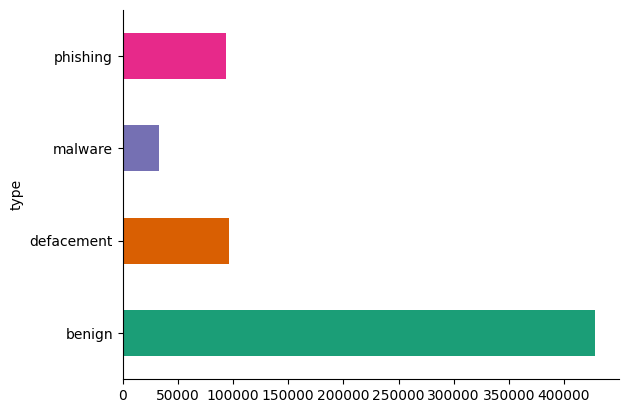

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)


# **Exploratory Data Analysis**

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [ ]:
# statistical analysis of the dataset
df.describe()

,url,type
count,651191,651191
unique,641119,4
top,http://style.org.hc360.com/css/detail/mysite/s...,benign
freq,180,428103


In [ ]:
# Features under type column
df['type'].unique()

array(['phishing', 'benign', 'defacement', 'malware'], dtype=object)

# **DATA PREPROCESSING**

In [ ]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["class_url"] = lb_make.fit_transform(df["type"])
df["class_url"].value_counts()

,count
class_url,
0,428103
1,96457
3,94111
2,32520


In [ ]:
def url_length(url):
    return len(str(url))

df['url_length'] = df['url'].apply(lambda i: url_length(i))
df

,url,type,class_url,url_length
0,br-icloud.com.br,phishing,3,16
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1,88
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235
...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,3,39
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,3,44
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,3,42
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,3,45


In [ ]:
from urllib.parse import urlparse

def hostname_length(url):
    return len(urlparse(url).netloc)

df['hostname_length'] = df['url'].apply(lambda i: hostname_length(i))
df

,url,type,class_url,url_length,hostname_length
0,br-icloud.com.br,phishing,3,16,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1,88,21
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,23
...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,3,39,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,3,44,0
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,3,42,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,3,45,0


In [ ]:
def count_www(url):
    url.count('www')
    return url.count('www')

df['count-www'] = df['url'].apply(lambda i: count_www(i))
df

,url,type,class_url,url_length,hostname_length,count-www
0,br-icloud.com.br,phishing,3,16,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1,88,21,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,23,0
...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,3,39,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,3,44,0,0
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,3,42,0,1
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,3,45,0,0


from matplotlib import pyplot as plt
df['class_url'].plot(kind='hist', bins=20, title='class_url')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['url_length'].plot(kind='hist', bins=20, title='url_length')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['hostname_length'].plot(kind='hist', bins=20, title='hostname_length')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['count-www'].plot(kind='hist', bins=20, title='count-www')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='class_url', y='url_length', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='url_length', y='hostname_length', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='hostname_length', y='count-www', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='count-www', y='count-https', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['google_index']
  ys = series['class_url']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('google_index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('type')):
  _plot_series(series, series_name, i)
  fig.legend(title='type', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('google_index')
_ = plt.ylabel('class_url')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['google_index']
  ys = series['url_length']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('google_index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('type')):
  _plot_series(series, series_name, i)
  fig.legend(title='type', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('google_index')
_ = plt.ylabel('url_length')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['google_index']
  ys = series['hostname_length']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('google_index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('type')):
  _plot_series(series, series_name, i)
  fig.legend(title='type', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('google_index')
_ = plt.ylabel('hostname_length')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['google_index']
  ys = series['count-www']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('google_index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('type')):
  _plot_series(series, series_name, i)
  fig.legend(title='type', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('google_index')
_ = plt.ylabel('count-www')

from matplotlib import pyplot as plt
df['class_url'].plot(kind='line', figsize=(8, 4), title='class_url')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['url_length'].plot(kind='line', figsize=(8, 4), title='url_length')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['hostname_length'].plot(kind='line', figsize=(8, 4), title='hostname_length')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['count-www'].plot(kind='line', figsize=(8, 4), title='count-www')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='class_url', y='type', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='url_length', y='type', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='hostname_length', y='type', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='count-www', y='type', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

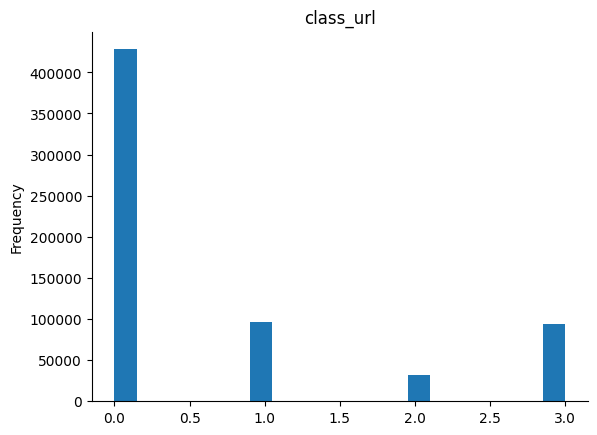

In [ ]:
from matplotlib import pyplot as plt
df['class_url'].plot(kind='hist', bins=20, title='class_url')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
def count_https(url):
    return url.count('https')

df['count-https'] = df['url'].apply(lambda i : count_https(i))

def count_http(url):
    return url.count('http')

df['count-http'] = df['url'].apply(lambda i : count_http(i))

In [ ]:
def count_dot(url):
    count_dot = url.count('.')
    return count_dot

df['count.'] = df['url'].apply(lambda i: count_dot(i))

def count_per(url):
    return url.count('%')

df['count%'] = df['url'].apply(lambda i : count_per(i))

def count_ques(url):
    return url.count('?')

df['count?'] = df['url'].apply(lambda i: count_ques(i))

def count_hyphen(url):
    return url.count('-')

df['count-'] = df['url'].apply(lambda i: count_hyphen(i))

def count_equal(url):
    return url.count('=')

df['count='] = df['url'].apply(lambda i: count_equal(i))

def count_atrate(url):

    return url.count('@')

df['count@'] = df['url'].apply(lambda i: count_atrate(i))

def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))

def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

df['count_embed_domian'] = df['url'].apply(lambda i: no_of_embed(i))
df

,url,type,class_url,url_length,hostname_length,count-www,count-https,count-http,count.,count%,count?,count-,count=,count@,count_dir,count_embed_domian
0,br-icloud.com.br,phishing,3,16,0,0,0,0,2,0,0,1,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0,0,0,0,2,0,0,0,0,0,2,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0,0,0,0,2,0,0,0,0,0,3,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1,88,21,1,0,1,3,0,1,1,4,0,1,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,23,0,0,1,2,0,1,1,3,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,3,39,0,0,0,0,3,0,0,0,0,0,3,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,3,44,0,0,0,0,2,0,0,2,0,0,4,0
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,3,42,0,1,0,0,2,0,0,0,0,0,4,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,3,45,0,0,0,0,2,0,0,0,0,0,2,0


In [ ]:
def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\…o\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

df['short_url'] = df['url'].apply(lambda i: shortening_service(i))

In [ ]:
!pip install tld

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 4.6 MB/s eta 0:00:00


In [ ]:
from tld import get_tld

#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df['fd_length'] = df['url'].apply(lambda i: fd_length(i))

#Length of Top Level Domain
df['tld'] = df['url'].apply(lambda i: get_tld(i,fail_silently=True))

def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))
df

,url,type,class_url,url_length,hostname_length,count-www,count-https,count-http,count.,count%,count?,count-,count=,count@,count_dir,count_embed_domian,short_url,fd_length,tld,tld_length
0,br-icloud.com.br,phishing,3,16,0,0,0,0,2,0,0,1,0,0,0,0,0,0,None,-1
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0,0,0,0,2,0,0,0,0,0,2,0,0,5,None,-1
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0,0,0,0,2,0,0,0,0,0,3,0,0,7,None,-1
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1,88,21,1,0,1,3,0,1,1,4,0,1,0,0,9,be,2
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,23,0,0,1,2,0,1,1,3,0,1,0,0,9,net,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,3,39,0,0,0,0,3,0,0,0,0,0,3,0,0,7,None,-1
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,3,44,0,0,0,0,2,0,0,2,0,0,4,0,1,8,None,-1
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,3,42,0,1,0,0,2,0,0,0,0,0,4,0,1,7,None,-1
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,3,45,0,0,0,0,2,0,0,0,0,0,2,0,0,4,None,-1


In [ ]:
def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0

df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))


def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

df['count-digits']= df['url'].apply(lambda i: digit_count(i))


def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters


df['count-letters']= df['url'].apply(lambda i: letter_count(i))
df

,url,type,class_url,url_length,hostname_length,count-www,count-https,count-http,count.,count%,...,count@,count_dir,count_embed_domian,short_url,fd_length,tld,tld_length,sus_url,count-digits,count-letters
0,br-icloud.com.br,phishing,3,16,0,0,0,0,2,0,...,0,0,0,0,0,None,-1,0,0,13
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0,0,0,0,2,0,...,0,2,0,0,5,None,-1,0,1,29
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0,0,0,0,2,0,...,0,3,0,0,7,None,-1,0,1,25
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1,88,21,1,0,1,3,0,...,0,1,0,0,9,be,2,0,7,63
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,23,0,0,1,2,0,...,0,1,0,0,9,net,3,0,22,199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,3,39,0,0,0,0,3,0,...,0,3,0,0,7,None,-1,0,12,21
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,3,44,0,0,0,0,2,0,...,0,4,0,1,8,None,-1,0,7,29
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,3,42,0,1,0,0,2,0,...,0,4,0,1,7,None,-1,0,3,33
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,3,45,0,0,0,0,2,0,...,0,2,0,0,4,None,-1,0,0,36


In [ ]:
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))
df

,url,type,class_url,url_length,hostname_length,count-www,count-https,count-http,count.,count%,...,count_dir,count_embed_domian,short_url,fd_length,tld,tld_length,sus_url,count-digits,count-letters,abnormal_url
0,br-icloud.com.br,phishing,3,16,0,0,0,0,2,0,...,0,0,0,0,None,-1,0,0,13,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0,0,0,0,2,0,...,2,0,0,5,None,-1,0,1,29,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0,0,0,0,2,0,...,3,0,0,7,None,-1,0,1,25,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1,88,21,1,0,1,3,0,...,1,0,0,9,be,2,0,7,63,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,23,0,0,1,2,0,...,1,0,0,9,net,3,0,22,199,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,3,39,0,0,0,0,3,0,...,3,0,0,7,None,-1,0,12,21,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,3,44,0,0,0,0,2,0,...,4,0,1,8,None,-1,0,7,29,0
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,3,42,0,1,0,0,2,0,...,4,0,1,7,None,-1,0,3,33,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,3,45,0,0,0,0,2,0,...,2,0,0,4,None,-1,0,0,36,0


In [ ]:
#Use of IP or not in domain
def having_ip_address(url: str) -> int:
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df['use_of_ip_address'] = df['url'].apply(lambda i: having_ip_address(i))
df

,url,type,class_url,url_length,hostname_length,count-www,count-https,count-http,count.,count%,...,count_embed_domian,short_url,fd_length,tld,tld_length,sus_url,count-digits,count-letters,abnormal_url,use_of_ip_address
0,br-icloud.com.br,phishing,3,16,0,0,0,0,2,0,...,0,0,0,None,-1,0,0,13,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0,0,0,0,2,0,...,0,0,5,None,-1,0,1,29,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0,0,0,0,2,0,...,0,0,7,None,-1,0,1,25,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1,88,21,1,0,1,3,0,...,0,0,9,be,2,0,7,63,1,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,23,0,0,1,2,0,...,0,0,9,net,3,0,22,199,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,3,39,0,0,0,0,3,0,...,0,0,7,None,-1,0,12,21,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,3,44,0,0,0,0,2,0,...,0,1,8,None,-1,0,7,29,0,0
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,3,42,0,1,0,0,2,0,...,0,1,7,None,-1,0,3,33,0,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,3,45,0,0,0,0,2,0,...,0,0,4,None,-1,0,0,36,0,0


In [ ]:
df['use_of_ip_address'].value_counts()

,count
use_of_ip_address,
0,643898
1,7293


In [ ]:
!pip install googlesearch-python

In [ ]:
from googlesearch import search
def google_index(url):
    site = search(url, 5)
    return 1 if site else 0
df['google_index'] = df['url'].apply(lambda i: google_index(i))
df

,url,type,class_url,url_length,hostname_length,count-www,count-https,count-http,count.,count%,...,short_url,fd_length,tld,tld_length,sus_url,count-digits,count-letters,abnormal_url,use_of_ip_address,google_index
0,br-icloud.com.br,phishing,3,16,0,0,0,0,2,0,...,0,0,None,-1,0,0,13,0,0,1
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0,0,0,0,2,0,...,0,5,None,-1,0,1,29,0,0,1
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0,0,0,0,2,0,...,0,7,None,-1,0,1,25,0,0,1
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1,88,21,1,0,1,3,0,...,0,9,be,2,0,7,63,1,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,23,0,0,1,2,0,...,0,9,net,3,0,22,199,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,3,39,0,0,0,0,3,0,...,0,7,None,-1,0,12,21,0,0,1
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,3,44,0,0,0,0,2,0,...,1,8,None,-1,0,7,29,0,0,1
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,3,42,0,1,0,0,2,0,...,1,7,None,-1,0,3,33,0,0,1
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,3,45,0,0,0,0,2,0,...,0,4,None,-1,0,0,36,0,0,1


In [ ]:
df.isnull().sum()

,0
url,0
type,0
class_url,0
url_length,0
hostname_length,0
count-www,0
count-https,0
count-http,0
count.,0
count%,0


In [ ]:
df.shape


(651191, 26)

**MODEL TRAINING AND TESTING**

In [ ]:
X = df[['use_of_ip_address','abnormal_url', 'google_index', 'count-www', 'count@',
           'count_dir', 'count_embed_domian', 'short_url', 'count-https',
           'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
           'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
           'count-letters']]

y = df['class_url']

In [ ]:
X

,use_of_ip_address,abnormal_url,google_index,count-www,count@,count_dir,count_embed_domian,short_url,count-https,count-http,...,count?,count-,count=,url_length,hostname_length,sus_url,fd_length,tld_length,count-digits,count-letters
0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,16,0,0,0,-1,0,13
1,0,0,1,0,0,2,0,0,0,0,...,0,0,0,35,0,0,5,-1,1,29
2,0,0,1,0,0,3,0,0,0,0,...,0,0,0,31,0,0,7,-1,1,25
3,0,1,1,1,0,1,0,0,0,1,...,1,1,4,88,21,0,9,2,7,63
4,0,1,1,0,0,1,0,0,0,1,...,1,1,3,235,23,0,9,3,22,199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,0,0,1,0,0,3,0,0,0,0,...,0,0,0,39,0,0,7,-1,12,21
651187,0,0,1,0,0,4,0,1,0,0,...,0,2,0,44,0,0,8,-1,7,29
651188,0,0,1,1,0,4,0,1,0,0,...,0,0,0,42,0,0,7,-1,3,33
651189,0,0,1,0,0,2,0,0,0,0,...,0,0,0,45,0,0,4,-1,0,36


In [ ]:
y

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, shuffle=True, random_state=5)

In [ ]:
print(f"X_train Shape : {X_train.shape}")
print(f"Y_train Shape : {y_train.shape}")
print(f"X_test  Shape : {X_test.shape}")
print(f"Y_test  Shape : {y_test.shape}")

X_train Shape : (520952, 21)
Y_train Shape : (520952,)
X_test  Shape : (130239, 21)
Y_test  Shape : (130239,)


In [ ]:
from sklearn.linear_model import LogisticRegression

classifier1 = LogisticRegression(max_iter=1000, random_state=0)
classifier1.fit(X_train.values, y_train.values)
y_pred1 = classifier1.predict(X_test.values)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# **Logistic Regression confusion Matrix**

> Indented block

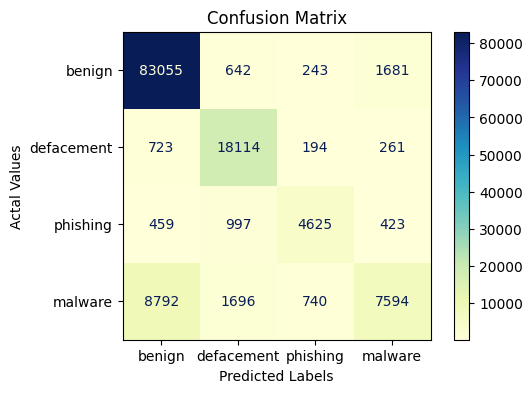

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Descriptive labels
labels = ["benign", "defacement", "phishing", "malware"]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Generate predictions
y_pred1 = classifier1.predict(X_test.values)

# Generate confusion matrix
cm1 = confusion_matrix(y_test, y_pred1, labels=classifier1.classes_)

# Generate confusion matrix display with descriptive labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=labels)
disp.plot(ax=ax, cmap='YlGnBu')  # colormap

# Set labels, title, and other parameters
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('Actal Values')
ax.set_title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_auc_score, fbeta_score

# Compute recall score
r_lgt = recall_score(y_test, y_pred1, average='weighted')
print("Recall Score1:", r_lgt)

# Compute precision score
p_lgt = precision_score(y_test, y_pred1, average='weighted')
print("Precision Score1:", p_lgt)

# Compute F1 score
f1_lgt = f1_score(y_test, y_pred1, average='weighted')
print("F1 Score1:", f1_lgt)

# Compute F2 score
f2_lgt = fbeta_score(y_test, y_pred1, beta=2, average='weighted')
print("F2 Score1:", f2_lgt)

# Compute accuracy score
A_lgt = accuracy_score(y_test, y_pred1)
print("Accuracy Score1:", A_lgt)


Recall Score1: 0.8706147928039988
Precision Score1: 0.8620342940374064
F1 Score1: 0.8567889969398107
F2 Score1: 0.8635710379275876
Accuracy Score1: 0.8706147928039988


# **KNeighborsClassifier**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

classifier2 = KNeighborsClassifier(metric='euclidean')
classifier2.fit(X_train.values, y_train.values)
y_pred2 = classifier2.predict(X_test.values)

# **KNeighborsClassifier Confusion Matrix**

> Indented block

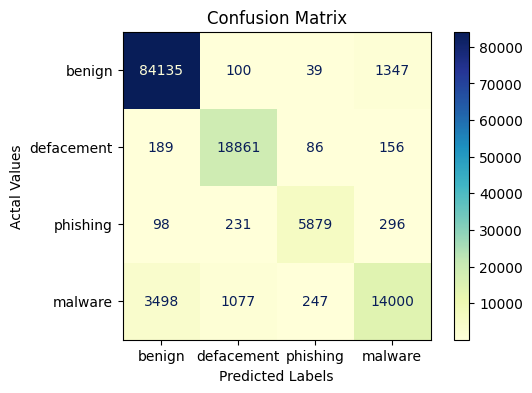

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Descriptive labels
labels = ["benign", "defacement", "phishing", "malware"]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Generate predictions
y_pred2 = classifier2.predict(X_test.values)

# Generate confusion matrix
cm2 = confusion_matrix(y_test, y_pred2, labels=classifier2.classes_)

# Generate confusion matrix display with descriptive labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=labels)
disp.plot(ax=ax, cmap='YlGnBu')  # colormap

# Set labels, title, and other parameters
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('Actal Values')
ax.set_title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_auc_score, fbeta_score

# Compute recall score
r_knn = recall_score(y_test, y_pred2, average='weighted')
print("Recall Score2:", r_knn)

# Compute precision score
p_knn = precision_score(y_test, y_pred2, average='weighted')
print("Precision Score2:", p_knn)

# Compute F1 score
f1_knn = f1_score(y_test, y_pred2, average='weighted')
print("F1 Score2:", f1_knn)

# Compute F2 score
f2_knn = fbeta_score(y_test, y_pred2, beta=2, average='weighted')
print("F2 Score2:", f2_knn)

# Compute accuracy score
A_knn = accuracy_score(y_test, y_pred2)
print("Accuracy Score2: ", A_knn)


Recall Score2: 0.943457796819693
Precision Score2: 0.941980221462466
F1 Score2: 0.9416048292281941
F2 Score2: 0.9424765494750298
Accuracy Score2:  0.943457796819693


# GaussianNB

> Indented block

In [ ]:
from sklearn.naive_bayes import GaussianNB

classifier3 = GaussianNB()
classifier3.fit(X_train.values, y_train.values)
y_pred3 = classifier3.predict(X_test.values)

# **GaussianNB Confusion Matrix**

> Indented block


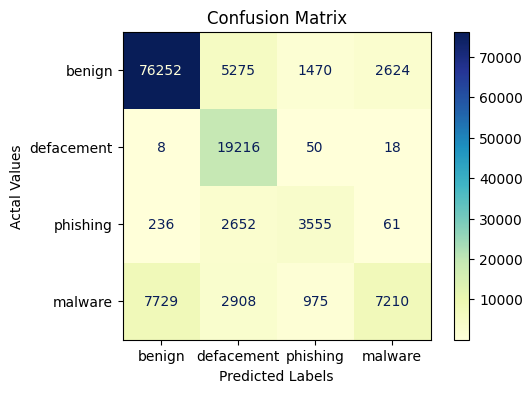

In [ ]:


# Descriptive labels
labels = ["benign", "defacement", "phishing", "malware"]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Generate predictions
y_pred3 = classifier3.predict(X_test.values)

# Generate confusion matrix
cm3 = confusion_matrix(y_test, y_pred3, labels=classifier3.classes_)

# Generate confusion matrix display with descriptive labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=labels)
disp.plot(ax=ax, cmap='YlGnBu')  # colormap

# Set labels, title, and other parameters
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('Actal Values')
ax.set_title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_auc_score, fbeta_score

# Compute recall score
r_nb = recall_score(y_test, y_pred3, average='weighted')
print("Recall Score3:", r_nb)

# Compute precision score
p_nb = precision_score(y_test, y_pred3, average='weighted')
print("Precision Score3:", p_nb)

# Compute F1 score
f1_nb = f1_score(y_test, y_pred3, average='weighted')
print("F1 Score3:", f1_nb)

# Compute F2 score
f2_nb = fbeta_score(y_test, y_pred3, beta=2, average='weighted')
print("F2 Score3:", f2_nb)

# Compute accuracy score
A_nb = accuracy_score(y_test, y_pred3)
print("Accuracy Score3:", A_nb)


Recall Score3: 0.8156773316748439
Precision Score3: 0.8243581621094763
F1 Score3: 0.8064690845421808
F2 Score3: 0.8089624146793432
Accuracy Score3: 0.8156773316748439


# **Decision Tree**
>

In [ ]:
from sklearn.tree import DecisionTreeClassifier

classifier4 = DecisionTreeClassifier(criterion = 'entropy', random_state=0)
classifier4.fit(X_train.values, y_train.values)
y_pred4 = classifier4.predict(X_test.values)

# **DecisionTree Confusion Matrix**


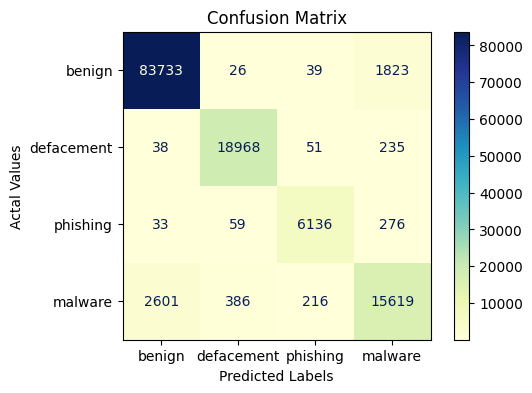

In [ ]:
# Descriptive labels
labels = ["benign", "defacement", "phishing", "malware"]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Generate predictions
y_pred4 = classifier4.predict(X_test.values)

# Generate confusion matrix
cm4 = confusion_matrix(y_test, y_pred4, labels=classifier4.classes_)

# Generate confusion matrix display with descriptive labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm4, display_labels=labels)
disp.plot(ax=ax, cmap='YlGnBu')  # colormap

# Set labels, title, and other parameters
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('Actal Values')
ax.set_title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_auc_score, fbeta_score

# Compute recall score
r_dt = recall_score(y_test, y_pred4, average='weighted')
print("Recall Score4:", r_dt)

# Compute precision score
p_dt = precision_score(y_test, y_pred4, average='weighted')
print("Precision Score4", p_dt)

# Compute F1 score
f1_dt = f1_score(y_test, y_pred4, average='weighted')
print("F1 Score4", f1_dt)

# Compute F2 score
f2_dt = fbeta_score(y_test, y_pred4, beta=2, average='weighted')
print("F2 Score4:", f2_dt)

# Compute accuracy score
A_dt = accuracy_score(y_test, y_pred4)
print("Accuracy Score4: ", A_dt)



Recall Score4: 0.95559701779037
Precision Score4 0.954920460903404
F1 Score4 0.9551736850303661
F2 Score4: 0.9554078609044224
Accuracy Score4:  0.95559701779037


# **Random Forest Classifier**

In [ ]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
classifier5 = RandomForestClassifier(n_estimators=100,max_features='sqrt')
classifier5.fit(X_train.values,y_train.values)
y_pred5 = classifier5.predict(X_test.values)

# **Confusion Matrix For Random Forest Classifier**

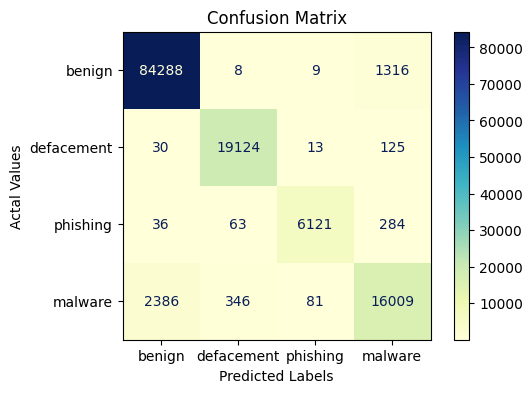

In [ ]:
# Descriptive labels
labels = ["benign", "defacement", "phishing", "malware"]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Generate predictions
y_pred5 = classifier5.predict(X_test.values)

# Generate confusion matrix
cm5 = confusion_matrix(y_test, y_pred5, labels=classifier5.classes_)

# Generate confusion matrix display with descriptive labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm5, display_labels=labels)
disp.plot(ax=ax, cmap='YlGnBu')  # colormap

# Set labels, title, and other parameters
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('Actal Values')
ax.set_title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, roc_auc_score, fbeta_score

# Compute recall score
r_rf = recall_score(y_test, y_pred5, average='weighted')
print("Recall Score5:", r_rf)

# Compute precision score
p_rf = precision_score(y_test, y_pred5, average='weighted')
print("Precision Score5:", p_rf)

# Compute F1 score
f1_rf = f1_score(y_test, y_pred5, average='weighted')
print("F1 Score5:", f1_rf)

# Compute F2 score
f2_rf = fbeta_score(y_test, y_pred5, beta=2, average='weighted')
print("F2 Score5:", f2_rf)

# Compute accuracy score
A_rf = accuracy_score(y_test, y_pred5)
print("Accuracy Score5:", A_rf)


Recall Score5: 0.9639355339030552
Precision Score5: 0.963371045843264
F1 Score5: 0.9634847093609649
F2 Score5: 0.9637161160901349
Accuracy Score5: 0.9639355339030552


## GENERAL MODEL EVALUATION (BEST MODEL SELECTION)

In [ ]:
# Define the model names
compare_models = ['Logistic Regression', 'KNeighborsClassifier', 'GaussianNB', 'RandomForestClassifier', 'DecisionTreeClassifier']

# Create DataFrame
data = {
    'Model': compare_models,
    'Accuracy': [A_lgt, A_knn, A_nb, A_rf, A_dt],
    'Recall': [r_lgt, r_knn, r_nb, r_rf, r_dt],
    'Precision': [p_lgt, p_knn, p_nb, p_rf, p_dt],
    'F1 Score': [f1_lgt, f1_knn, f1_nb, f1_rf, f1_dt],
    'F2 Score': [f2_lgt, f2_knn, f2_nb, f2_rf, f2_dt],
    'Description': ['', '', '', 'best model', '']
}

result = pd.DataFrame(data=data)
result



,Model,Accuracy,Recall,Precision,F1 Score,F2 Score,Description
0,Logistic Regression,0.870615,0.870615,0.862034,0.856789,0.863571,
1,KNeighborsClassifier,0.943458,0.943458,0.941980,0.941605,0.942477,
2,GaussianNB,0.815677,0.815677,0.824358,0.806469,0.808962,
3,RandomForestClassifier,0.963936,0.963936,0.963371,0.963485,0.963716,best model
4,DecisionTreeClassifier,0.955597,0.955597,0.954920,0.955174,0.955408,


# **Class Prediction**

In [ ]:
def get_url(url):

    status = []

    status.append(having_ip_address(url))
    status.append(abnormal_url(url))
    status.append(count_dot(url))
    status.append(count_www(url))
    status.append(count_atrate(url))
    status.append(no_of_dir(url))
    status.append(no_of_embed(url))

    status.append(shortening_service(url))
    status.append(count_https(url))
    status.append(count_http(url))

    status.append(count_per(url))
    status.append(count_ques(url))
    status.append(count_hyphen(url))
    status.append(count_equal(url))

    status.append(url_length(url))
    status.append(hostname_length(url))
    status.append(suspicious_words(url))
    status.append(digit_count(url))
    status.append(letter_count(url))
    status.append(fd_length(url))
    tld = get_tld(url,fail_silently=True)

    status.append(tld_length(tld))

    return status

In [ ]:
def model_predict1(test_url):
    features_test = get_url(test_url)
    features_test = np.array(features_test).reshape((1, -1))

    pred = classifier1.predict(features_test)
    if int(pred[0]) == 0:
        res="Bening"
        return res

    elif int(pred[0]) == 1:
        res="Defacement"
        return res

    elif int(pred[0]) == 2:
        res="Phising"
        return res

    elif int(pred[0]) == 3:
        res="Malware"
        return res

def model_predict2(test_url):
    features_test = get_url(test_url)
    features_test = np.array(features_test).reshape((1, -1))

    pred = classifier2.predict(features_test)
    if int(pred[0]) == 0:
        res="Bening"
        return res

    elif int(pred[0]) == 1:
        res="Defacement"
        return res

    elif int(pred[0]) == 2:
        res="Phising"
        return res

    elif int(pred[0]) == 3:
        res="Malware"
        return res
def model_predict3(test_url):
    features_test = get_url(test_url)
    features_test = np.array(features_test).reshape((1, -1))

    pred = classifier3.predict(features_test)
    if int(pred[0]) == 0:
        res="Bening"
        return res

    elif int(pred[0]) == 1:
        res="Defacement"
        return res

    elif int(pred[0]) == 2:
        res="Phising"
        return res

    elif int(pred[0]) == 3:
        res="Malware"
        return res

def model_predict4(test_url):
    features_test = get_url(test_url)
    features_test = np.array(features_test).reshape((1, -1))

    pred = classifier4.predict(features_test)
    if int(pred[0]) == 0:
        res="Bening"
        return res

    elif int(pred[0]) == 1:
        res="Defacement"
        return res

    elif int(pred[0]) == 2:
        res="Phising"
        return res

    elif int(pred[0]) == 3:
        res="Malware"
        return res

def model_predict5(test_url):
    features_test = get_url(test_url)
    features_test = np.array(features_test).reshape((1, -1))

    pred = classifier5.predict(features_test)
    if int(pred[0]) == 0:
        res="Bening"
        return res

    elif int(pred[0]) == 1:
        res="Defacement"
        return res

    elif int(pred[0]) == 2:
        res="Phising"
        return res

    elif int(pred[0]) == 3:
        res="Malware"
        return res

In [ ]:

!pip freeze > requirements.txt


In [ ]:
urls = ['www.kaggle.com',
        'en.wikipedia.org/wiki/Main_Page',
        'http://www.garage-pirenne.be/index.php?option=com_content&view=article&id=70&vsig70_0=15',
        'bopsecrets.org/rexroth/cr/1.htm',
       'www.stackoverflow.com/questions/',
       'www.google.com/','www.angelfire.com/goth/devilmaycrytonite/',
        'br-icloud.com.br']
print("----------------------------------------------")
print("LogisticRegression")
for url in urls:
     print(model_predict1(url))

print("----------------------------------------------")
print("KNeighborsClassifier")
for url in urls:
     print(model_predict2(url))

print("----------------------------------------------")
print("GaussianNB")
for url in urls:
     print(model_predict3(url))

print("----------------------------------------------")
print("DecisionTreeClassifier")
for url in urls:
     print(model_predict4(url))

print("----------------------------------------------")
print("RandomForest")
for url in urls:
     print(model_predict5(url))

----------------------------------------------
LogisticRegression
Malware
Bening
Malware
Bening
Malware
Malware
Malware
Bening
----------------------------------------------
KNeighborsClassifier
Malware
Malware
Malware
Malware
Malware
Malware
Malware
Malware
----------------------------------------------
GaussianNB
Malware
Malware
Phising
Malware
Malware
Malware
Malware
Malware
----------------------------------------------
DecisionTreeClassifier
Bening
Malware
Phising
Bening
Bening
Bening
Bening
Malware
----------------------------------------------
RandomForest
Bening
Bening
Defacement
Bening
Bening
Bening
Bening
Malware
